### Time+PSD를 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


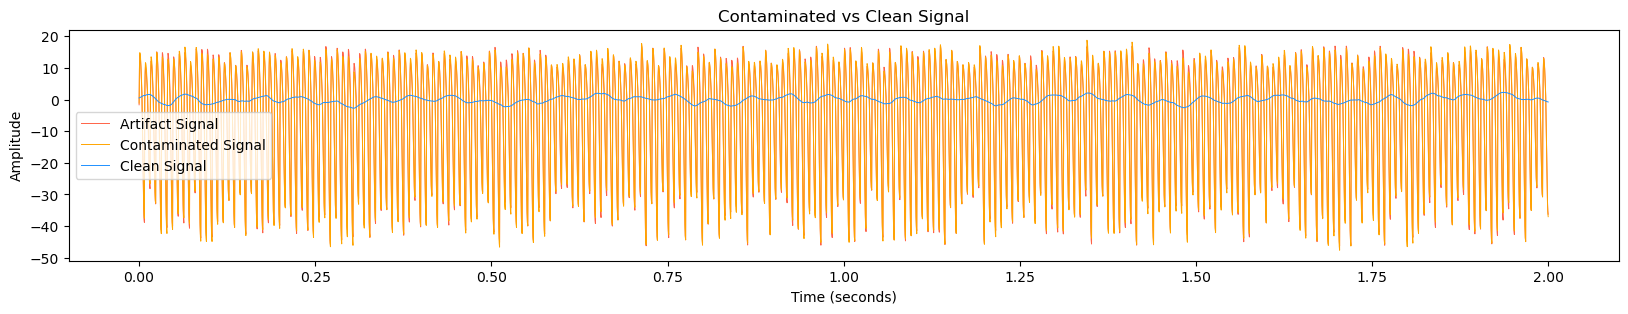

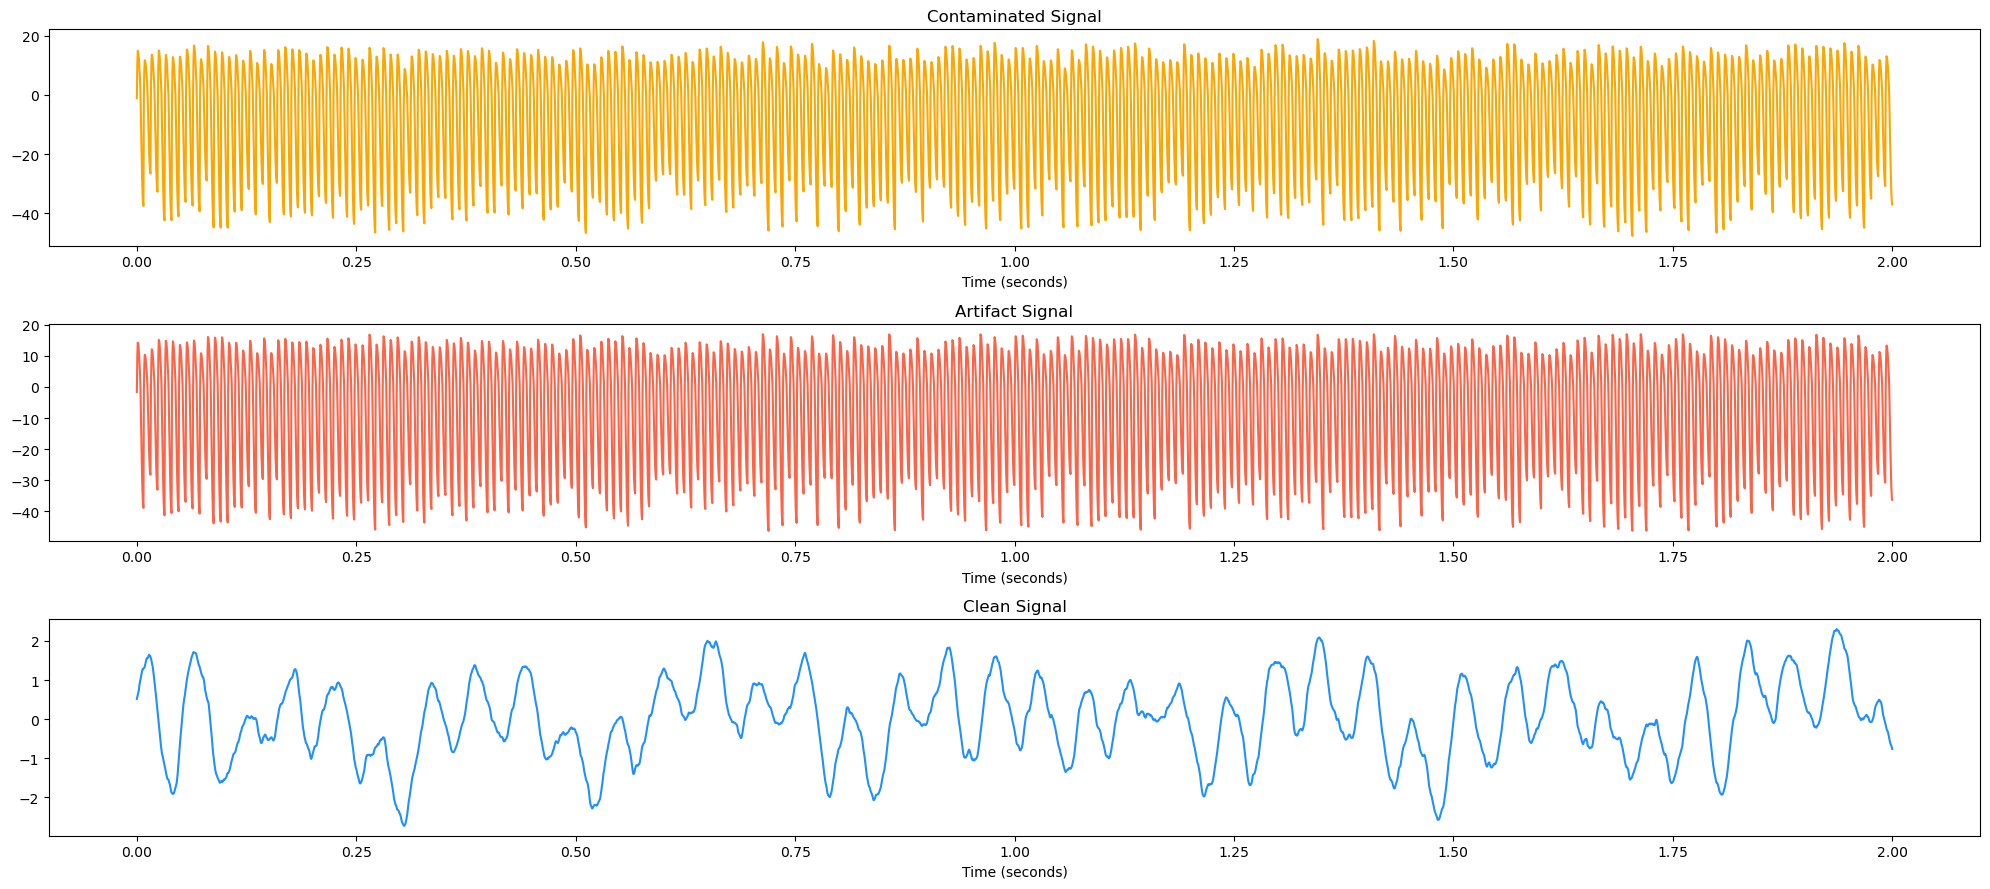

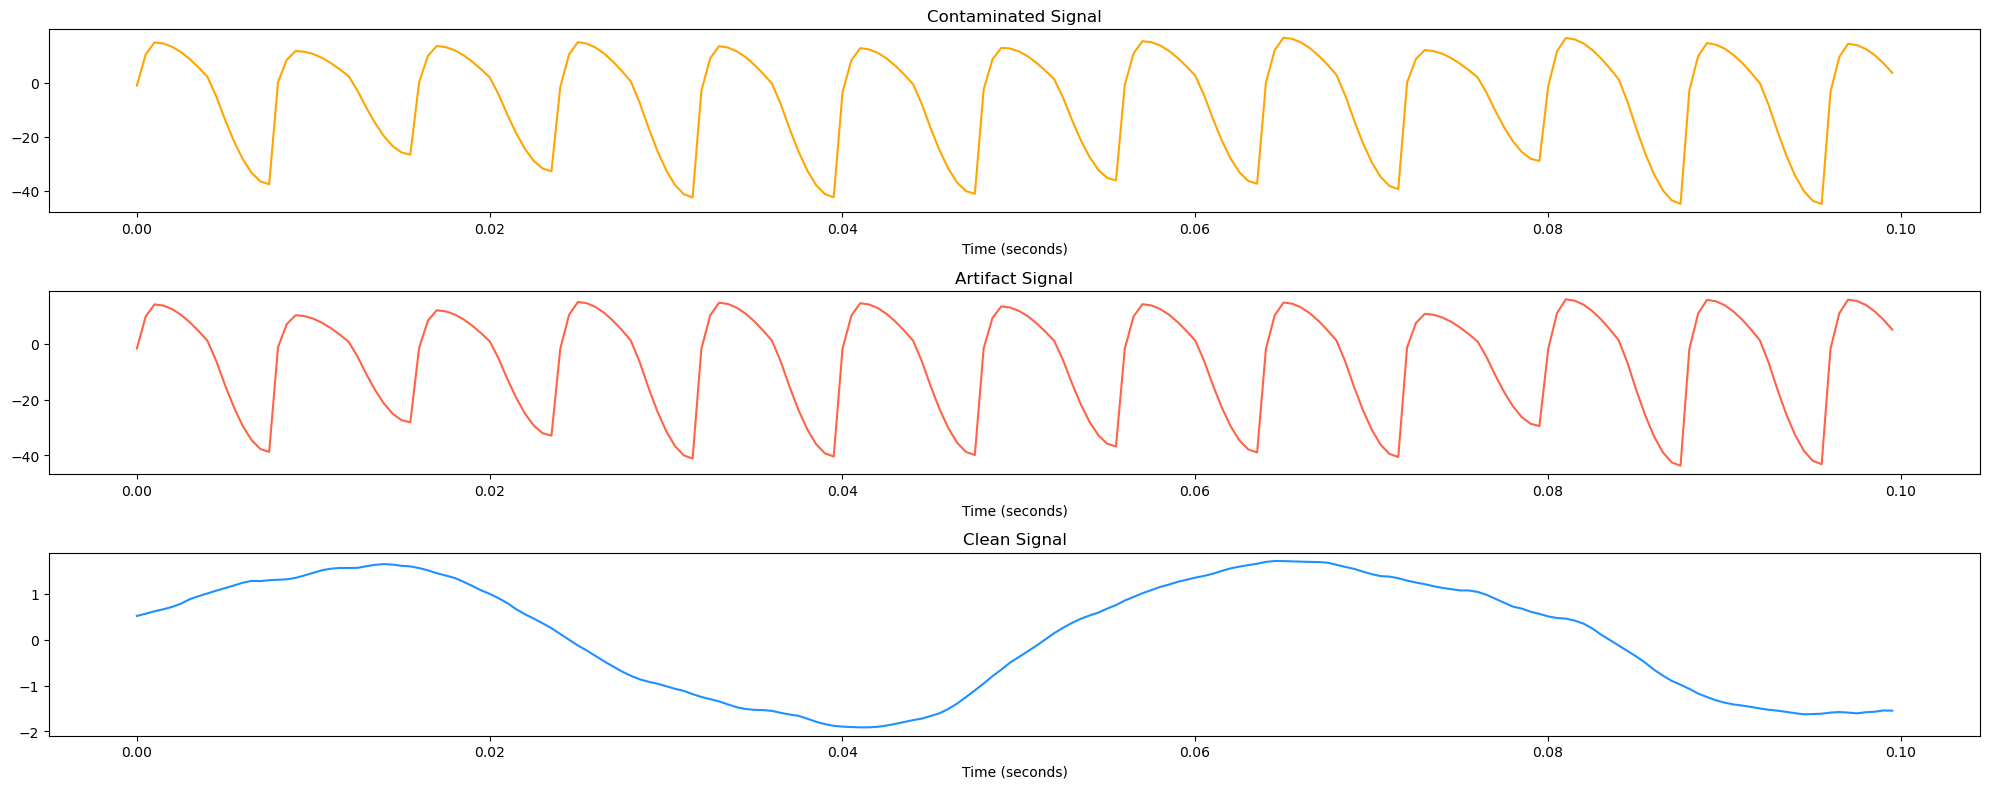

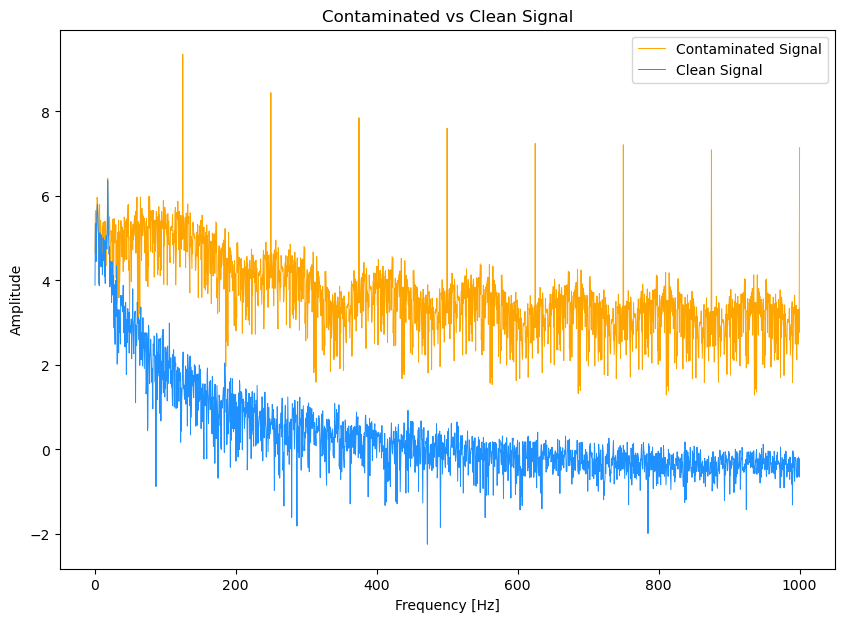

In [2]:
# 데이터 load & plot
datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X_single, y_single, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# PSD 붙이기

X_double = []
y_double = []

for xx, yy in zip(X_single, y_single):
    _, _, _, x_psd = FFT(xx, fs=2000, single_sided=False)
    _, _, _, y_psd = FFT(yy, fs=2000, single_sided=False)
    X_double.append(np.stack((xx, x_psd), axis=1))
    y_double.append(np.stack((yy, y_psd), axis=1))

X_double = np.transpose(np.array(X_double), (0, 2, 1))
y_double = np.transpose(np.array(y_double), (0, 2, 1))

print(X_double.shape)

(1000, 2, 4000)


In [5]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X_double, y_double, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 2, 4000)
y_train shape: (800, 2, 4000)
-----------------------------
X_test shape: (200, 2, 4000)
y_test shape: (200, 2, 4000)
-----------------------------


In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(CNN, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        # Decoding path
        self.upconv4 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv1d(64, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        x4 = self.pool(self.gelu(self.conv4(x3)))

        # Decoding
        x4_up = self.upconv4(x4)
        x3_up = self.upconv3(x4_up)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

In [7]:
num_samples = 4000
height = 12
width = 2000

model = CNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

CNN(
  (conv1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv4): ConvTranspose1d(512, 256, kernel_size=(2,), stride=(2,))
  (upconv3): ConvTranspose1d(256, 128, kernel_size=(2,), stride=(2,))
  (upconv2): ConvTranspose1d(128, 64, kernel_size=(2,), stride=(2,))
  (upconv1): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  (gelu): GELU(approximate='none')
)


In [8]:
# 모델 학습
num_epochs = 1000

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)

        y_pred_double = []
        for yy in y_pred.squeeze():
            yy = yy.detach().cpu()
            _, _, _, y_psd = FFT(yy.detach().cpu(), fs=2000, single_sided=False)
            y_pred_double.append(np.stack((yy, y_psd), axis=1))
        y_pred_double = np.transpose(np.array(y_pred_double), (0, 2, 1))
        y_pred_double = torch.tensor(y_pred_double, dtype=torch.float32, requires_grad=True).to(device)

        loss = criterion(y_pred_double, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')

Epoch [1/1000] | Loss: 25.625117797851562
Epoch [2/1000] | Loss: 25.6251180267334
Epoch [3/1000] | Loss: 25.62511749267578
Epoch [4/1000] | Loss: 25.62511749267578
Epoch [5/1000] | Loss: 25.6251171875
Epoch [6/1000] | Loss: 25.625117416381837
Epoch [7/1000] | Loss: 25.625117263793946
Epoch [8/1000] | Loss: 25.62511787414551
Epoch [9/1000] | Loss: 25.62511749267578
Epoch [10/1000] | Loss: 25.62511749267578
Epoch [11/1000] | Loss: 25.62511764526367
Epoch [12/1000] | Loss: 25.625117797851562
Epoch [13/1000] | Loss: 25.62511764526367
Epoch [14/1000] | Loss: 25.625116958618165
Epoch [15/1000] | Loss: 25.62511749267578
Epoch [16/1000] | Loss: 25.625117568969728
Epoch [17/1000] | Loss: 25.625117263793946
Epoch [18/1000] | Loss: 25.625117416381837
Epoch [19/1000] | Loss: 25.62511734008789
Epoch [20/1000] | Loss: 25.625117568969728
Epoch [21/1000] | Loss: 25.62511772155762
Epoch [22/1000] | Loss: 25.625117111206055
Epoch [23/1000] | Loss: 25.625117416381837
Epoch [24/1000] | Loss: 25.6251177215

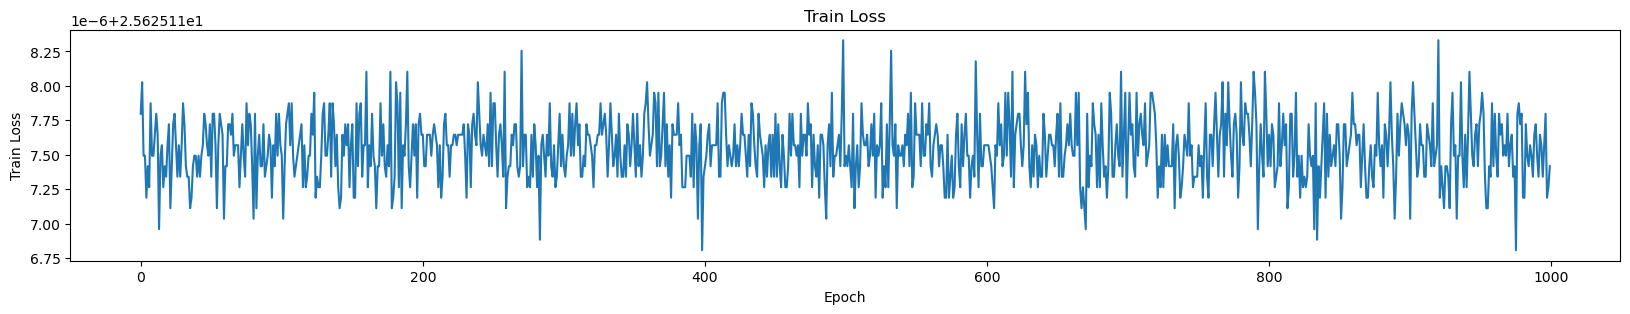

Minimal Train Loss: 1 [0]



In [9]:
# Train Loss Plot
Train_Loss_Plot(loss_list)

In [17]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        y_pred_double = []
        for yy in y_pred.squeeze():
            yy = yy.detach().cpu()
            _, _, _, y_psd = FFT(yy.detach().cpu(), fs=2000, single_sided=False)
            y_pred_double.append(np.stack((yy, y_psd), axis=1))
        y_pred_double = np.transpose(np.array(y_pred_double), (0, 2, 1))
        y_pred_double = torch.tensor(y_pred_double, dtype=torch.float32, requires_grad=True).to(device)

        loss = criterion(y_pred_double, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x[:,0,:].squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred[:,0,:].squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y[:,0,:].squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 25.6250


torch.Size([200, 4000])
<Time Domain Error>
Mean Absolute Error: 9.27922534171448
Mean Squared Error: 92.67407298050247


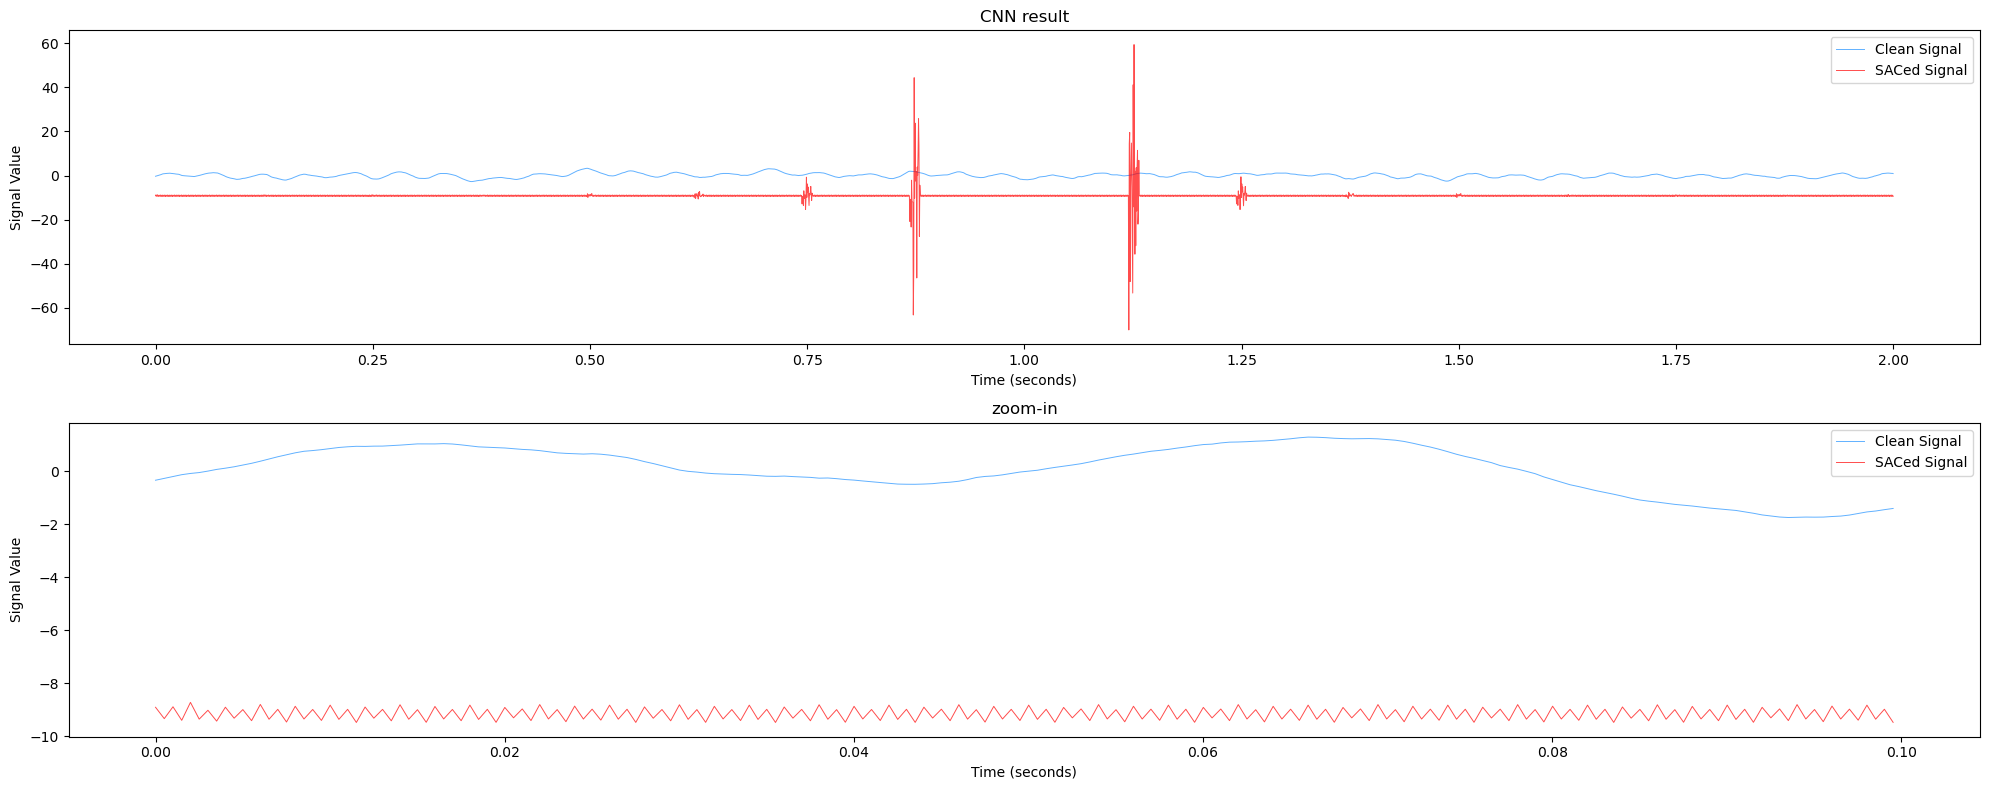

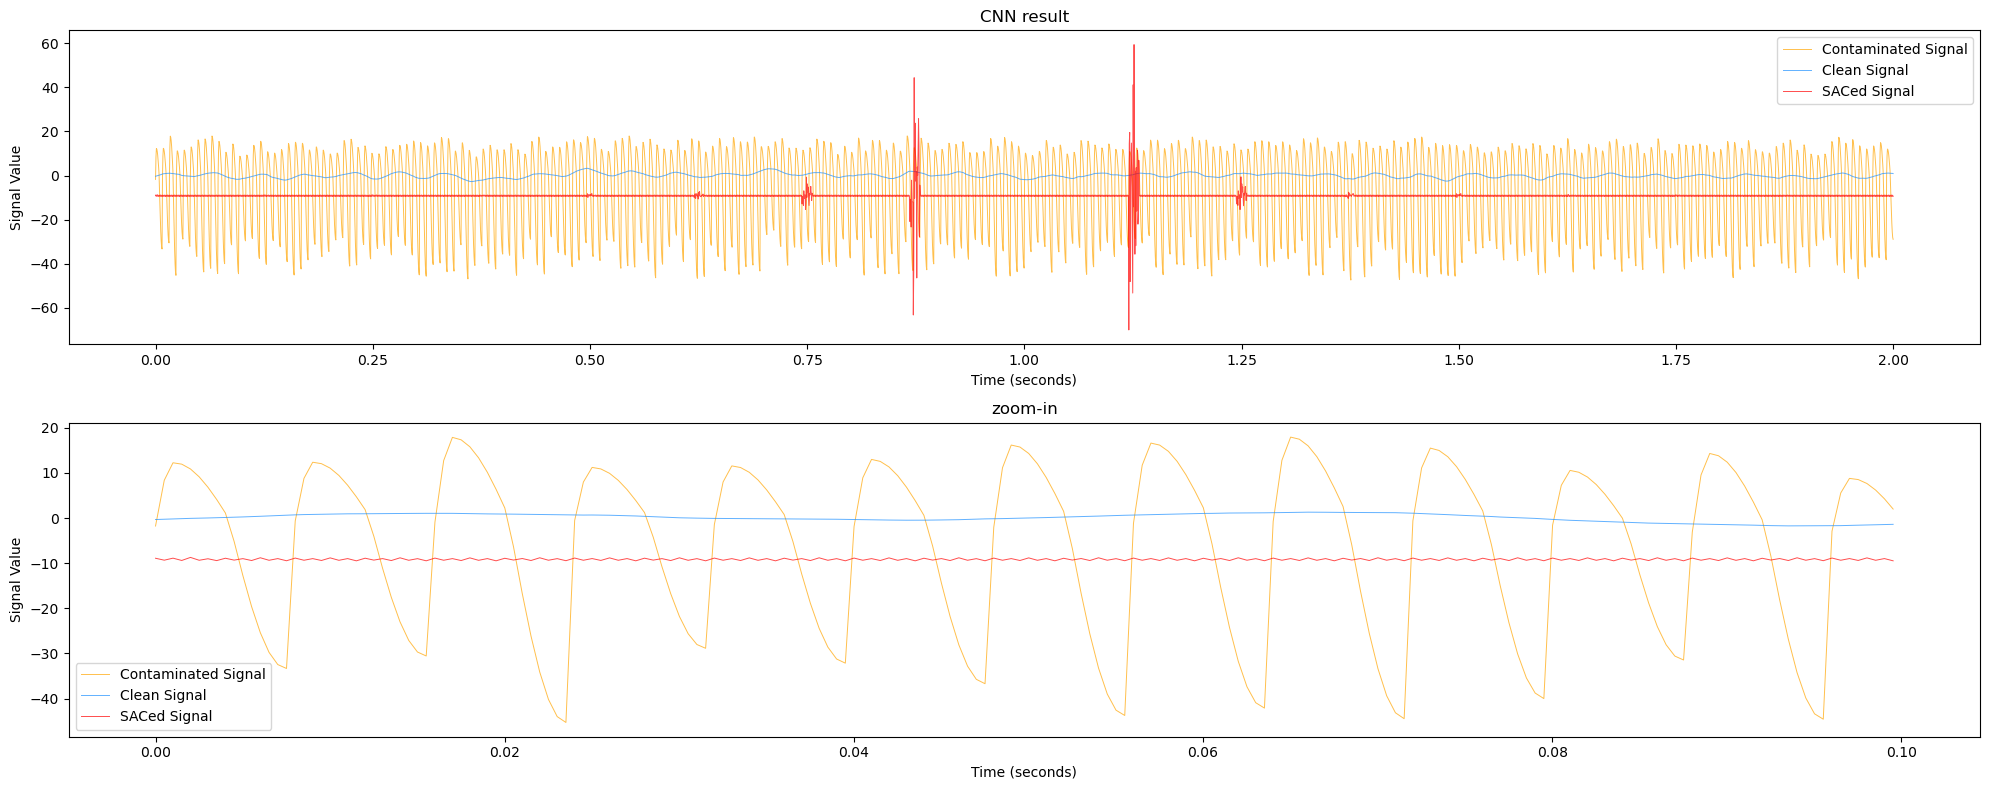

<Frequency Domain Error>
Mean Absolute Error: 4.013081524857813
Mean Squared Error: 18.257276392730763


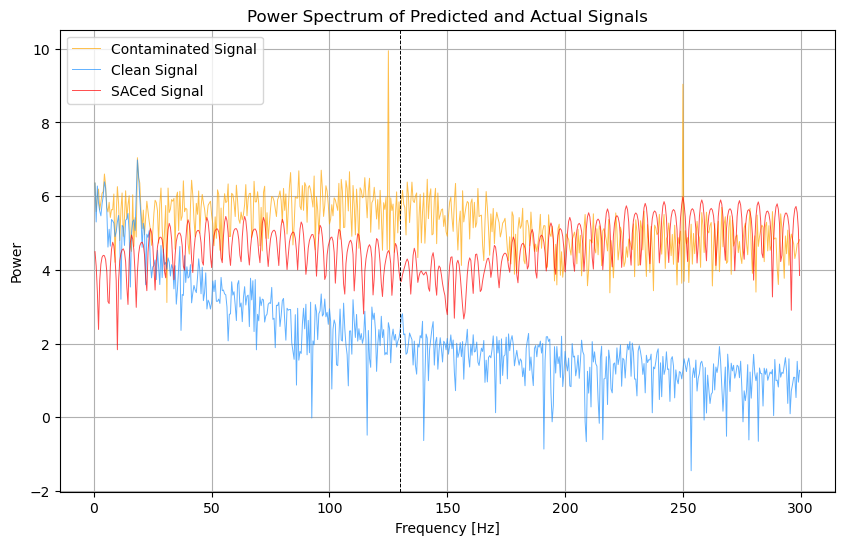

In [18]:
print(Contaminated.shape)

# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

In [ ]:
# 원래 scale
Result_Plot(Contaminated, SACed, Clean)